In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [46]:
def read_csv_dataset(file_name):
    df = pd.read_csv(file_name)
    print('Formato do dataset: ',df.shape)
    print('Feature Engineering...')
    date_split = df['Month'].str.split('-').str
    df['Year'], df['Month'] = date_split
    m = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12, }
    df['Month'] = df['Month'].map(m)
    df.drop(df.columns[[3,4,5,6]], axis=1, inplace=True) #vou só ficar com as colunas 0,1,2,6
    df.drop(df.tail(2).index,inplace=True) #eliminar as duas últimas linhas com lixo
    df.dropna() #just to be sure
    df["Year"] = df["Year"].astype(dtype=np.float64) #converter coluna do ano para floats
    print('Formato do dataset: ',df.shape)
    return df

In [47]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - tam_sequencia): #numero de registos - tamanho da sequencia
         res.append(mat_dados[i: i + tam_sequencia])
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    train = res[:qt_casos_treino, :]
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,-1] #para ir buscar o último atributo para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    
    return [x_train, y_train, x_test, y_test]

In [48]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 4), return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [49]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i],racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [50]:
def LSTM_():
    df = read_csv_dataset("advertising-and-sales-data-36-co.csv")
    print("df", df.shape)
    janela = 6 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    #model = build_model(janela)
    model = build_model2(janela)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    print_series_prediction(y_test,predic)
    # MSE- (Mean square error), RMSE- (root mean square error) - 
    # o significado de RMSE depende do range da label. para o mesmo range menor é melhor.

In [51]:
def print_model(model,fich):
 from keras.utils import plot_model
 plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

Formato do dataset:  (38, 7)
Feature Engineering...
Formato do dataset:  (36, 4)
df (36, 4)
X_train (26, 6, 4)
y_train (26,)
X_test (3, 6, 4)
y_test (3,)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Train on 23 samples, validate on 3 samples
Epoch 1/500
23/23 [==============================] - 2s 91ms/step - loss: 4.6522 - acc: 0.0000e+00 - val_loss: 0.9837 - val_acc: 0.0000e+00
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 4.6232 - acc: 0.0000e+00 - val_loss: 0.9678 - val_acc: 0.0000e+00
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 4.5930 - acc: 0.0000e+00 - val_loss: 0.9518 - val_acc: 0.0000e+00
Epoch 4/500
23/23 [==============================] - 0s 2ms/step - loss: 4.5623 - acc: 0.0000e+00 - val_loss: 0.9341 - val_acc: 0.0000e+00
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 4.5278 - acc: 0.0000e+00 - val_loss: 0.9152 - val_acc: 0.0000e+00
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 4.4868 - acc: 0.0000e+00 - val_loss: 0.8948 - val_acc: 0.0000e+00
Epoch 7/500
23/23 [==============================] - 0s 2ms/step - loss: 4.4426 - acc: 0.0000e+00 - val_loss: 0.8727 - val

Epoch 61/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5143 - acc: 0.5217 - val_loss: 1.5545 - val_acc: 0.0000e+00
Epoch 62/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5177 - acc: 0.5217 - val_loss: 1.5662 - val_acc: 0.0000e+00
Epoch 63/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5196 - acc: 0.5217 - val_loss: 1.5690 - val_acc: 0.0000e+00
Epoch 64/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5201 - acc: 0.5217 - val_loss: 1.5636 - val_acc: 0.0000e+00
Epoch 65/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5192 - acc: 0.5217 - val_loss: 1.5508 - val_acc: 0.0000e+00
Epoch 66/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5171 - acc: 0.5217 - val_loss: 1.5317 - val_acc: 0.0000e+00
Epoch 67/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5141 - acc: 0.5217 - val_loss: 1.5073 - val_acc: 0.0000e+00
Epoch 68/500
23/23 [============================

23/23 [==============================] - 0s 2ms/step - loss: 0.4765 - acc: 0.5217 - val_loss: 1.1114 - val_acc: 0.0000e+00
Epoch 122/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4765 - acc: 0.5217 - val_loss: 1.1090 - val_acc: 0.0000e+00
Epoch 123/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4765 - acc: 0.5217 - val_loss: 1.1065 - val_acc: 0.0000e+00
Epoch 124/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.1039 - val_acc: 0.0000e+00
Epoch 125/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.1012 - val_acc: 0.0000e+00
Epoch 126/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 127/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0960 - val_acc: 0.0000e+00
Epoch 128/500
23/23 [==============================] - 

Epoch 181/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0880 - val_acc: 0.0000e+00
Epoch 182/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0880 - val_acc: 0.0000e+00
Epoch 183/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0879 - val_acc: 0.0000e+00
Epoch 184/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0880 - val_acc: 0.0000e+00
Epoch 185/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0880 - val_acc: 0.0000e+00
Epoch 186/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0880 - val_acc: 0.0000e+00
Epoch 187/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0881 - val_acc: 0.0000e+00
Epoch 188/500
23/23 [====================

Epoch 241/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 242/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 243/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 244/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 245/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 246/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 247/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0889 - val_acc: 0.0000e+00
Epoch 248/500
23/23 [====================

Epoch 301/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 302/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 303/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 304/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 305/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 306/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 307/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 308/500
23/23 [====================

Epoch 361/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 362/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 363/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 364/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 365/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 366/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 367/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 368/500
23/23 [====================

Epoch 421/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 422/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 423/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 424/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 425/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 426/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 427/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 428/500
23/23 [====================

Epoch 481/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 482/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 483/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 484/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 485/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 486/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 487/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4764 - acc: 0.5217 - val_loss: 1.0888 - val_acc: 0.0000e+00
Epoch 488/500
23/23 [====================

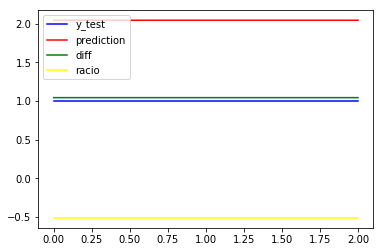

In [52]:
if __name__ == '__main__':
 #visualize_GOOGL()
 LSTM_()